# **Import Library**

In [1]:
# General Utilities
import os
import shutil
from shutil import copyfile
import zipfile
import random
from random import sample
import pathlib
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd

# Progress Bar
from tqdm.notebook import tqdm as tq

# Image Processing
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from PIL import Image

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG19
from sklearn.utils import class_weight
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import drive for Google Colab
from google.colab import drive

# Import File
from google.colab import files

# **Data Preparation**

## **Load Data**

In [2]:
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

zip_path = '/content/drive/MyDrive/Capstone/1. Machine Learning/Dataset/Dataset Jerawat/capstone.zip'
extract_path = '/content/dataset'

# Cek apakah zip ada di Drive
if not os.path.exists(zip_path):
    print(f"Error: Zip file not found at {zip_path}")
    print("Please verify the path to your zip file in Google Drive.")
else:
    if not os.path.exists(extract_path):
        os.makedirs(extract_path, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print("Zip file berhasil diekstrak.")
    else:
        print("Folder sudah diekstrak sebelumnya.")

# Path ke folder Acne-detection-1 di dalam folder ekstraksi
acne_path = os.path.join(extract_path, 'Acne-detection-1')

if os.path.exists(acne_path):
    print("Folder dataset:", acne_path)
    print("Isi folder dataset:", os.listdir(acne_path))
else:
    print(f"Folder {acne_path} tidak ditemukan. Cek proses ekstraksi atau isi zip.")

Mounted at /content/drive
Zip file berhasil diekstrak.
Folder dataset: /content/dataset/Acne-detection-1
Isi folder dataset: ['README.roboflow.txt', 'test', 'valid', 'README.dataset.txt', 'train']


In [3]:
acne_path = '/content/dataset/Acne-detection-1'
if os.path.exists(acne_path):
    shutil.rmtree(acne_path)
    print("Folder Acne-detection-1 dihapus untuk ekstraksi ulang.")

Folder Acne-detection-1 dihapus untuk ekstraksi ulang.


In [4]:
zip_path = '/content/drive/MyDrive/Capstone/1. Machine Learning/Dataset/Dataset Jerawat/capstone.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Ekstrak ulang selesai.")

Ekstrak ulang selesai.


In [5]:
print("Isi folder Acne-detection-1 setelah ekstrak ulang:", os.listdir(acne_path))

Isi folder Acne-detection-1 setelah ekstrak ulang: ['README.roboflow.txt', 'test', 'valid', 'README.dataset.txt', 'train']


In [6]:
base_path = '/content/dataset/Acne-detection-1'
grouped_path = '/content/dataset/Acne-detection-1-grouped'

splits = ['train', 'test', 'valid']

# Fungsi ambil kata pertama dari nama folder kelas
def get_first_word(folder_name):
    if '_' in folder_name:
        return folder_name.split('_')[0]
    return folder_name.split(' ')[0]

# Mengumpulkan semua kata pertama dari semua folder kelas di train, test, valid
all_first_words = set()
for split in splits:
    split_path = os.path.join(base_path, split)
    class_folders = os.listdir(split_path)
    for folder in class_folders:
        first_word = get_first_word(folder)
        all_first_words.add(first_word)

print(f"Kelas utama yang ditemukan: {sorted(all_first_words)}")

# Buat folder baru untuk setiap kelas utama di grouped_path
for split in splits:
    for main_class in all_first_words:
        os.makedirs(os.path.join(grouped_path, split, main_class), exist_ok=True)

# Copy file ke folder grouped sesuai kelas utama
for split in splits:
    original_split_path = os.path.join(base_path, split)
    grouped_split_path = os.path.join(grouped_path, split)

    class_folders = os.listdir(original_split_path)
    for class_folder in class_folders:
        first_word = get_first_word(class_folder)
        src_folder = os.path.join(original_split_path, class_folder)
        dst_folder = os.path.join(grouped_split_path, first_word)

        for file_name in os.listdir(src_folder):
            src_file = os.path.join(src_folder, file_name)
            dst_file = os.path.join(dst_folder, file_name)

            if not os.path.exists(dst_file):
                shutil.copy2(src_file, dst_file)
        print(f"Copied from {src_folder} to {dst_folder}")

print("Selesai grouping dataset secara otomatis berdasarkan kata pertama kelas.")

Kelas utama yang ditemukan: ['Acne', 'Blackhead', 'Blackhead Cystic Flat', 'Blackhead Flat', 'Conglobata', 'Crystanlline', 'Cystic', 'Cystic Flat', 'Flat', 'Folliculitis', 'Keloid', 'Milium', 'Papular', 'Purulent', 'Scars', 'Sebo-crystan-conglo', 'Syringoma', 'Whitehead']
Copied from /content/dataset/Acne-detection-1/train/Blackhead Cystic Folliculitis Purulent Whitehead to /content/dataset/Acne-detection-1-grouped/train/Blackhead
Copied from /content/dataset/Acne-detection-1/train/Cystic Flat_wart Papular Sebo-crystan-conglo Whitehead to /content/dataset/Acne-detection-1-grouped/train/Cystic Flat
Copied from /content/dataset/Acne-detection-1/train/Flat_wart Papular Scars Whitehead to /content/dataset/Acne-detection-1-grouped/train/Flat
Copied from /content/dataset/Acne-detection-1/train/Blackhead Flat_wart Papular Purulent to /content/dataset/Acne-detection-1-grouped/train/Blackhead Flat
Copied from /content/dataset/Acne-detection-1/train/Blackhead Flat_wart Purulent Sebo-crystan-cong

In [7]:
grouped_path = '/content/dataset/Acne-detection-1-grouped'
splits = ['train', 'test', 'valid']

for split in splits:
    print(f"\n--- Isi folder '{split}' dan jumlah file per kelas ---")
    split_path = os.path.join(grouped_path, split)
    classes = os.listdir(split_path)
    for cls in sorted(classes):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            num_files = len(os.listdir(cls_path))
            print(f"{cls}: {num_files} file")


--- Isi folder 'train' dan jumlah file per kelas ---
Acne: 13764 file
Blackhead: 1258 file
Blackhead Cystic Flat: 46 file
Blackhead Flat: 148 file
Conglobata: 21 file
Crystanlline: 92 file
Cystic: 395 file
Cystic Flat: 80 file
Flat: 333 file
Folliculitis: 171 file
Keloid: 200 file
Milium: 193 file
Papular: 683 file
Purulent: 82 file
Scars: 13 file
Sebo-crystan-conglo: 18 file
Syringoma: 26 file
Whitehead: 32 file

--- Isi folder 'test' dan jumlah file per kelas ---
Acne: 673 file
Blackhead: 62 file
Blackhead Cystic Flat: 2 file
Blackhead Flat: 9 file
Conglobata: 0 file
Crystanlline: 8 file
Cystic: 21 file
Cystic Flat: 3 file
Flat: 11 file
Folliculitis: 8 file
Keloid: 6 file
Milium: 9 file
Papular: 27 file
Purulent: 2 file
Scars: 0 file
Sebo-crystan-conglo: 1 file
Syringoma: 2 file
Whitehead: 1 file

--- Isi folder 'valid' dan jumlah file per kelas ---
Acne: 1229 file
Blackhead: 112 file
Blackhead Cystic Flat: 5 file
Blackhead Flat: 23 file
Conglobata: 0 file
Crystanlline: 12 file
Cyst

# **Data Preprocessing**


## **Transformasi Manual**

In [8]:
# Path train dataset yang sudah dikelompokkan
train_dir = '/content/dataset/Acne-detection-1-grouped/train'

IMG_SIZE = 64
BATCH_SIZE = 32

# Mapping class ke label angka berdasar nama folder train
class_name_label = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(train_dir)))}
print("Class label mapping:", class_name_label)

num_classes = len(class_name_label)
print("Number of classes:", num_classes)

# Fungsi augmentasi / transformasi gambar

def anticlockwise_rotation(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    k = random.randint(1, 3)
    return tf.image.rot90(img, k=k)

def clockwise_rotation(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    k = random.randint(1, 3)
    return tf.image.rot90(img, k=4 - k)

def flip_up_down(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.image.flip_up_down(img)

def add_brightness(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    delta = random.uniform(0.1, 0.5)
    return tf.image.adjust_brightness(img, delta=delta)

def blur_image(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=30, max_jpeg_quality=100, seed=(1, 2))

def sheared(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    datagen = ImageDataGenerator(shear_range=0.2)
    img_exp = tf.expand_dims(img, 0)
    return next(iter(datagen.flow(img_exp)))[0]

def warp_shift(img):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img_exp = tf.expand_dims(img, 0)
    return next(iter(datagen.flow(img_exp)))[0]

# Dictionary transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

Class label mapping: {'Acne': 0, 'Blackhead': 1, 'Blackhead Cystic Flat': 2, 'Blackhead Flat': 3, 'Conglobata': 4, 'Crystanlline': 5, 'Cystic': 6, 'Cystic Flat': 7, 'Flat': 8, 'Folliculitis': 9, 'Keloid': 10, 'Milium': 11, 'Papular': 12, 'Purulent': 13, 'Scars': 14, 'Sebo-crystan-conglo': 15, 'Syringoma': 16, 'Whitehead': 17}
Number of classes: 18


## **Data Augmentation**

In [9]:
def load_data(path, augment=False):
    images, labels = [], []
    for folder in os.listdir(path):
        if folder not in class_name_label:
            continue
        label = class_name_label[folder]
        folder_path = os.path.join(path, folder)
        for file in os.listdir(folder_path):
            try:
                img_path = os.path.join(folder_path, file)
                img = tf.io.read_file(img_path)
                img = tf.image.decode_jpeg(img, channels=3)
                img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
                img = tf.cast(img, tf.float32) / 255.0

                images.append(img.numpy())
                labels.append(label)

                if augment:
                    key = random.choice(list(transformations.keys()))
                    transformed_img = transformations[key](img)

                    if tf.is_tensor(transformed_img):
                        transformed_img = tf.clip_by_value(transformed_img, 0, 1)
                        transformed_img = transformed_img.numpy()
                    else:
                        transformed_img = np.clip(transformed_img, 0, 1)

                    images.append(transformed_img)
                    labels.append(label)

            except Exception as e:
                print(f"Error loading image {file} in folder {folder}: {e}")
                continue

    return np.array(images), np.array(labels)


# Load data dari folder yang sudah dikelompokkan
train_dir = '/content/dataset/Acne-detection-1-grouped/train'
val_dir = '/content/dataset/Acne-detection-1-grouped/valid'
test_dir = '/content/dataset/Acne-detection-1-grouped/test'

train_images, train_labels = load_data(train_dir, augment=True)
val_images, val_labels = load_data(val_dir, augment=False)
test_images, test_labels = load_data(test_dir, augment=False)

print("Train images:", train_images.shape)
print("Validation images:", val_images.shape)
print("Test images:", test_images.shape)

# One-hot encode labels
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
val_labels_one_hot = to_categorical(val_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

# Buat ImageDataGenerator
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Buat data generator dari numpy arrays dan one-hot labels
train_generator = train_datagen.flow(train_images, train_labels_one_hot, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_images, val_labels_one_hot, batch_size=BATCH_SIZE, shuffle=False)
test_generator = test_datagen.flow(test_images, test_labels_one_hot, batch_size=BATCH_SIZE, shuffle=False)

Train images: (35110, 64, 64, 3)
Validation images: (1591, 64, 64, 3)
Test images: (845, 64, 64, 3)


# **Modeling**

## **Model Sequential, Conv2D, Pooling Layer. Transfer Learning : VGG19**

In [10]:
# Parameter
IMG_SIZE = 64
num_classes = 18
BATCH_SIZE = 32
EPOCHS = 20

# Simple CNN dengan Sequential

simple_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

simple_cnn.summary()

# Compile simple CNN
simple_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685,522 (2.62 MB)

 Trainable params: 685,522 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Transfer Learning dengan VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

# Fine-tune 5 layer terakhir
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

# Compile model
model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 2, 2, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,162,386 (76.91 MB)

 Trainable params: 9,576,210 (36.53 MB)

 Non-trainable params: 10,586,176 (40.38 MB)

In [12]:
# Training dengan callbacks

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1098/1098 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - accuracy: 0.7654 - loss: 0.8292 - val_accuracy: 0.7725 - val_loss: 0.7304 - learning_rate: 1.0000e-04
Epoch 2/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.7941 - loss: 0.6565 - val_accuracy: 0.7725 - val_loss: 0.7438 - learning_rate: 1.0000e-04
Epoch 3/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.8083 - loss: 0.5955 - val_accuracy: 0.7511 - val_loss: 0.8387 - learning_rate: 1.0000e-04
Epoch 4/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8346 - loss: 0.5065 - val_accuracy: 0.7561 - val_loss: 0.7790 - learning_rate: 5.0000e-05
Epoch 5/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.8626 - loss: 0.4190 - val_accuracy: 0.7605 - val_loss: 0.8715 - learning_rate: 5.0000e-05
Epoch 6/20
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 43s 39ms/step - accuracy: 0.9014 - loss: 0.3053 - val_accuracy: 0.7674 - val_loss: 0.9866 - learning_rate: 2.5000e-05


# **Evaluasi Model**

In [13]:
# Evaluasi model di test set

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.8000 - loss: 0.6794
Test Loss: 0.6715
Test Accuracy: 0.7941


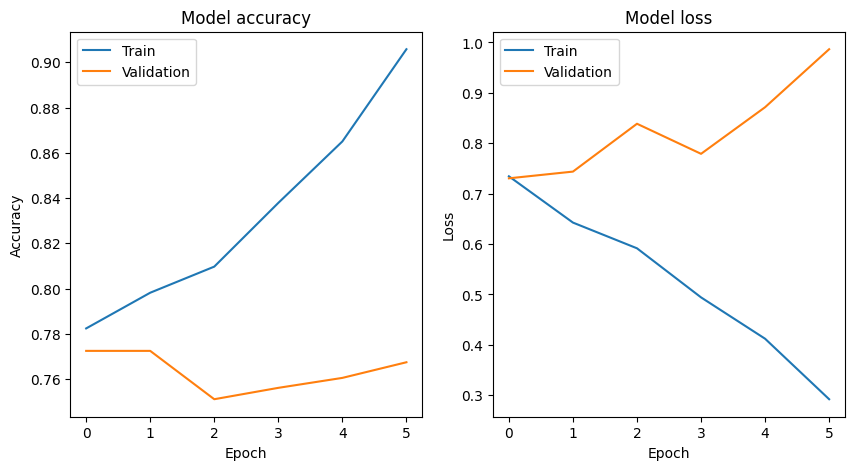

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Menyimpan Model**

In [15]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_one_hot, axis=1)

# Simpan model ke HDF5 (.h5)
model.save('model.h5')

# Simpan ke format Keras resmi (.keras)
model.save('model.keras')

# Simpan ke format TensorFlow SavedModel (.pb + variables/)
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)

# Konversi ke TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Zip folder SavedModel untuk diunduh
shutil.make_archive('saved_model', 'zip', export_dir)

# Unduh semua file
files.download('model.h5')
files.download('model.keras')
files.download('model.tflite')
files.download('saved_model.zip')

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Inference**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


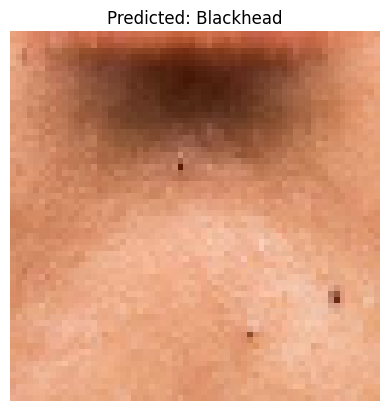

In [16]:
IMG_SIZE = 64
class_labels = list(class_name_label.keys())

def display_prediction(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    plt.imshow(np.array(img).astype("uint8"))
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis('off')
    plt.show()

test_image_path = "/content/dataset/Acne-detection-1-grouped/test/Blackhead/blackhead-20-_jpg.rf.451ed6b75c21de3809bdab4b5a2e344d.jpg"

display_prediction(test_image_path, model, class_labels)